In [1]:
!pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import json
from sqlalchemy import create_engine
import psycopg2
from mplsoccer import VerticalPitch,Pitch
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

import os

In [3]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
cd drive/MyDrive/Portfolio/

/content/drive/MyDrive/Portfolio


In [2]:
# Classify progressive pass based on opta definition
# Progressive passes aim to capture this and are defined as “completed open-play passes in the attacking two-thirds of the pitch that move the ball at least 25% closer to the goal
def is_progressive_pass(row):
    pitch_length = 100  # Length of the pitch in meters
    goal_width = 7.32  # Standard goal width in meters
    attacking_two_thirds_start = pitch_length / 3  # 33.33 meters from the goal
    
    # Closest y position on the goal line
    closest_y_on_goal = min(max(row['y'], (50 - goal_width / 2)), (50 + goal_width / 2))
    closest_y_on_goal_end = min(max(row['end_y'], (50 - goal_width / 2)), (50 + goal_width / 2))
    
    # Calculate initial and final distances to the closest point on the goal line
    initial_distance_to_goal = ((pitch_length - row['x'])**2 + (closest_y_on_goal - row['y'])**2)**0.5
    final_distance_to_goal = ((pitch_length - row['end_x'])**2 + (closest_y_on_goal_end - row['end_y'])**2)**0.5
    
    return (row['x'] > attacking_two_thirds_start and 
            row['end_x'] > row['x'] and 
            final_distance_to_goal <= initial_distance_to_goal * 0.75)



## Plot Take On

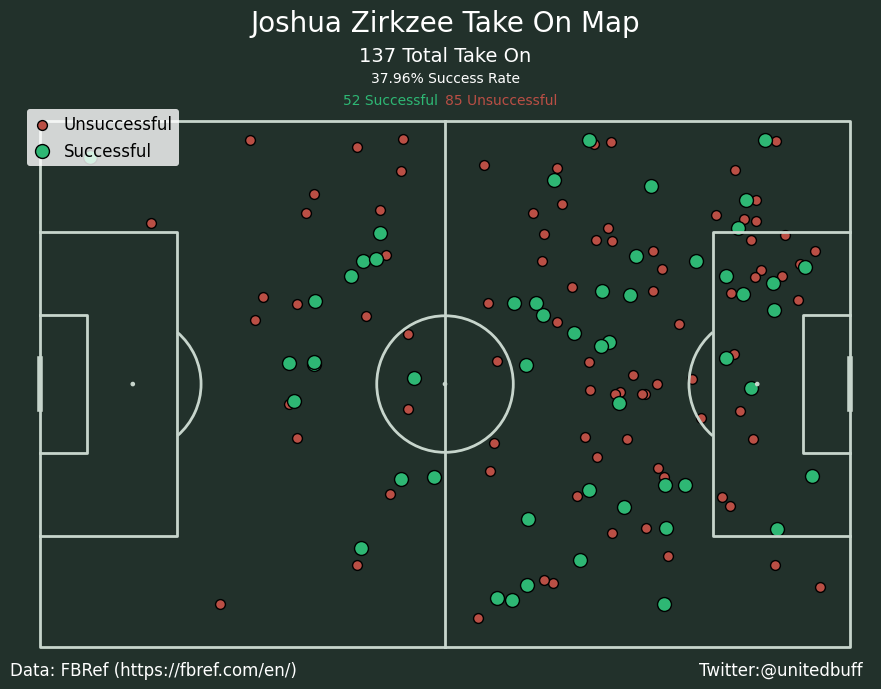

In [154]:
def plot_take_on_map(playerName):
  to_success = take_on_events.loc[take_on_events.outcome_type_display_name=='Successful']
  to_fail = take_on_events.loc[take_on_events.outcome_type_display_name=='Unsuccessful']

  # Set up the pitch
  to_success_count = len(to_success.index)
  to_fail_count = len(to_fail.index)
  try:
      to_rate = round(to_success_count/(to_fail_count + to_success_count) *100,2)
  except ZeroDivisionError:
      to_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  fig.set_facecolor('#22312b')

  pitch.scatter(to_fail.x, to_fail.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Unsuccessful')
  pitch.scatter(to_success.x, to_success.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Successful')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

  # Set the title
  ax_title = ax.set_title(f'{playerName} Take On Map', fontsize=20,color='white', pad=50)
  ax.text(0.5, 1.08, f'{to_success_count + to_fail_count} Total Take On', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
  ax.text(0.5, 1.04, f'{to_rate}% Success Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
  ax.text(0.38, 1, f'{to_success_count} Successful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
  ax.text(0.5, 1, f'{to_fail_count} Unsuccessful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')
  ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
  ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
  #ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')
plot_take_on_map(playerName)

## Plot Tackle

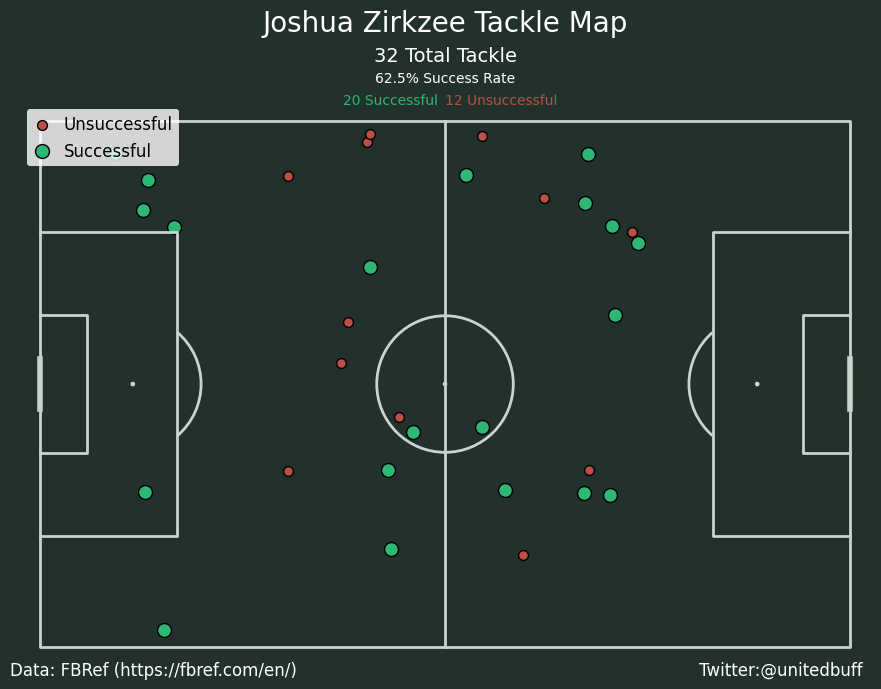

In [155]:
def plot_tackle_map(playerName):
  tackle_success = tackle_events.loc[tackle_events.outcome_type_display_name=='Successful']
  tackle_fail = tackle_events.loc[tackle_events.outcome_type_display_name=='Unsuccessful']

  # Set up the pitch
  tackle_success_count = len(tackle_success.index)
  tackle_fail_count = len(tackle_fail.index)
  try:
      tackle_rate = round(tackle_success_count/(tackle_fail_count + tackle_success_count) *100,2)
  except ZeroDivisionError:
      tackle_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  fig.set_facecolor('#22312b')

  pitch.scatter(tackle_fail.x, tackle_fail.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Unsuccessful')
  pitch.scatter(tackle_success.x, tackle_success.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Successful')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

  # Set the title
  ax_title = ax.set_title(f'{playerName} Tackle Map', fontsize=20,color='white', pad=50)
  ax.text(0.5, 1.08, f'{tackle_success_count + tackle_fail_count} Total Tackle', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
  ax.text(0.5, 1.04, f'{tackle_rate}% Success Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
  ax.text(0.38, 1, f'{tackle_success_count} Successful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
  ax.text(0.5, 1, f'{tackle_fail_count} Unsuccessful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')
  ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
  ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_tackle_map(playerName)

## Plot Interception

In [5]:
def plot_interception_map(playerName):
  interception_success = interception_events.loc[interception_events.outcome_type_display_name=='Successful']
  interception_fail = interception_events.loc[interception_events.outcome_type_display_name=='Unsuccessful']

  # Set up the pitch
  interception_success_count = len(interception_success.index)
  interception_fail_count = len(interception_fail.index)
  try:
      interception_rate = round(interception_success_count/(interception_fail_count + interception_success_count) *100,2)
  except ZeroDivisionError:
      interception_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  #fig.set_facecolor('#22312b')

  pitch.scatter(interception_fail.x, interception_fail.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Unsuccessful')
  pitch.scatter(interception_success.x, interception_success.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Successful')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

  # Set the title
  ax_title = ax.set_title(f'{playerName} Interception Map', fontsize=20)
  fig.text(0.28, 0.69, f'{interception_success_count} Successful', ha='left', va='baseline', fontsize=12, color='#2eb774')
  fig.text(0.28, 0.66, f'{interception_fail_count} Unsucessful', ha='left', va='baseline', fontsize=12, color='#ba4f45')
  fig.text(0.28, 0.63, f'{interception_rate}% Interception Success Rate', ha='left', va='baseline', fontsize=12, color='white')
  #ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')

## Plot Pass Map

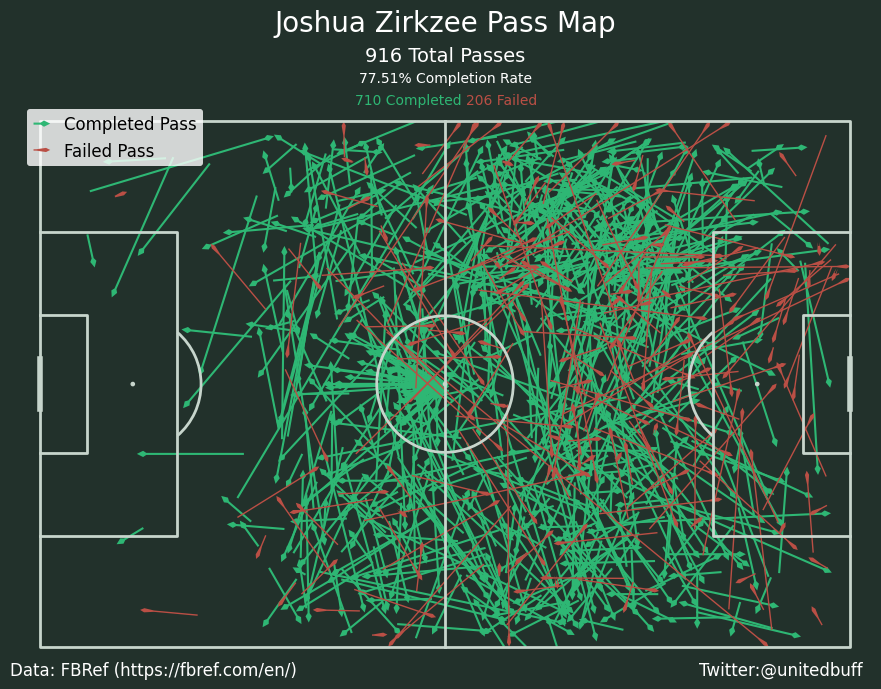

In [145]:
def plot_pass_map(playerName):
  pass_success = passing.loc[passing.outcome_type_display_name=='Successful']
  pass_fail = passing.loc[passing.outcome_type_display_name=='Unsuccessful']

  # Set up the pitch
  pass_success_count = len(pass_success.index)
  pass_fail_count = len(pass_fail.index)
  try:
      pass_rate = round(pass_success_count/(pass_success_count + pass_fail_count) *100,2)
  except ZeroDivisionError:
      pass_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  fig.set_facecolor('#22312b')

  # Plot the completed passes
  pitch.arrows(pass_success.x, pass_success.y,
              pass_success.end_x, pass_success.end_y, width=1.5,
              headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

  # Plot the other passes
  pitch.arrows(pass_fail.x, pass_fail.y,
              pass_fail.end_x, pass_fail.end_y, width=1,
              headwidth=3, headlength=3, headaxislength=10,
              color='#ba4f45', ax=ax, label='Failed Pass')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')
  #fig.text(0.15, 0.65, f'{pass_success_count} Completed', ha='left', va='baseline', fontsize=11, color='#2eb774')
  #fig.text(0.15, 0.62, f'{pass_fail_count} Failed', ha='left', va='baseline', fontsize=11, color='#ba4f45')
  #fig.text(0.14, 0.61, f'{pass_rate}%', ha='left', va='baseline', fontsize=11, color='white')
  # Set the title
  ax_title = ax.set_title(f'{playerName} Pass Map', fontsize=20,color='white', pad=50)
  ax.text(0.5, 1.08, f'{pass_success_count + pass_fail_count} Total Passes', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
  ax.text(0.5, 1.04, f'{pass_rate}% Completion Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
  ax.text(0.395, 1, f'{pass_success_count} Completed', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
  ax.text(0.525, 1, f'{pass_fail_count} Failed', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')
  ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
  ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_pass_map(playerName)

## Progressive Pass Map

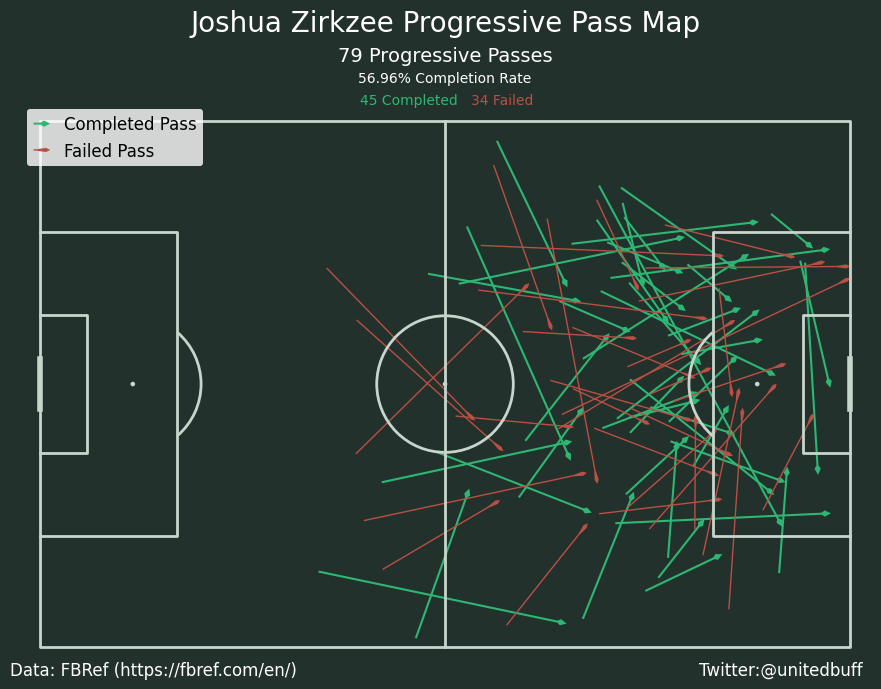

In [140]:
def plot_progressive_pass_map(playerName):
  passing['is_progressive'] = passing.apply(is_progressive_pass, axis=1)
  progressive_pass = passing[passing['is_progressive']].reset_index(drop=True)
  progressive_pass_success = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Successful']
  progressive_pass_fail = progressive_pass.loc[progressive_pass.outcome_type_display_name=='Unsuccessful']
  # Set up the pitch
  progressive_pass_success_count = len(progressive_pass_success.index)
  progressive_pass_fail_count = len(progressive_pass_fail.index)
  try:
      progressive_pass_rate = round(progressive_pass_success_count/(progressive_pass_success_count + progressive_pass_fail_count) *100,2)
  except ZeroDivisionError:
      progressive_pass_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  fig.set_facecolor('#22312b')

  # Plot the completed passes
  pitch.arrows(progressive_pass_success.x, progressive_pass_success.y,
              progressive_pass_success.end_x, progressive_pass_success.end_y, width=1.5,
              headwidth=3, headlength=3, color='#2eb774', ax=ax, label='Completed Pass')

  # Plot the other passes
  pitch.arrows(progressive_pass_fail.x, progressive_pass_fail.y,
              progressive_pass_fail.end_x, progressive_pass_fail.end_y, width=1,
              headwidth=3, headlength=3, headaxislength=10,
              color='#ba4f45', ax=ax, label='Failed Pass')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

  # Set the title
  ax_title = ax.set_title(f'{playerName} Progressive Pass Map', fontsize=20,color='white', pad=50)
  ax.text(0.5, 1.08, f'{progressive_pass_success_count + progressive_pass_fail_count} Progressive Passes', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
  ax.text(0.5, 1.04, f'{progressive_pass_rate}% Completion Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
  ax.text(0.4, 1, f'{progressive_pass_success_count} Completed', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
  ax.text(0.53, 1, f'{progressive_pass_fail_count} Failed', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')

  ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
  ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
  #ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')
plot_progressive_pass_map(playerName)


## Plot Receive Pass

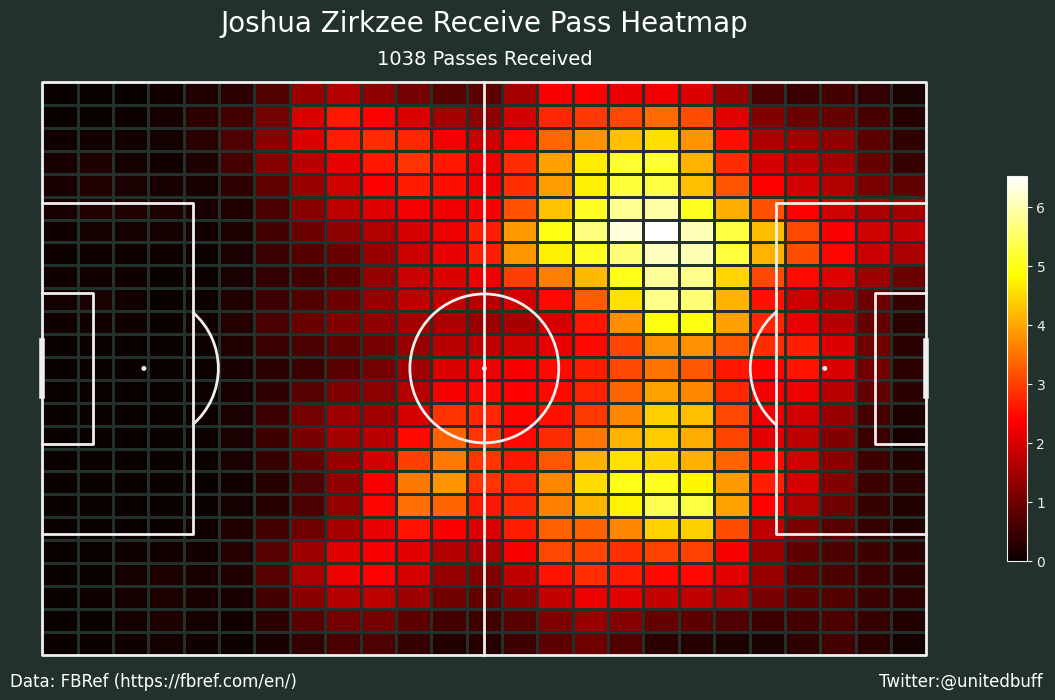

In [58]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter

def plot_receive_pass_map(playerName):
    # Initialize pitch
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,
                  pitch_color='#22312b', line_color='#efefef')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    # Calculate statistics for the heatmap
    rp_count = len(receive_pass.index)
    bin_statistic = pitch.bin_statistic(receive_pass.end_x, receive_pass.end_y, statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)

    # Plot heatmap
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')

    # Add title and subtitle
    ax_title = ax.set_title(f'{playerName} Receive Pass Heatmap', fontsize=20, color='white', pad=20)
    ax.text(0.5, 1, f'{rp_count} Passes Received', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')

    # Customize colorbar
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

    # Add footer text
    ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(1.1, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 

    plt.show()
plot_receive_pass_map(playerName)

## Plot Shots Map

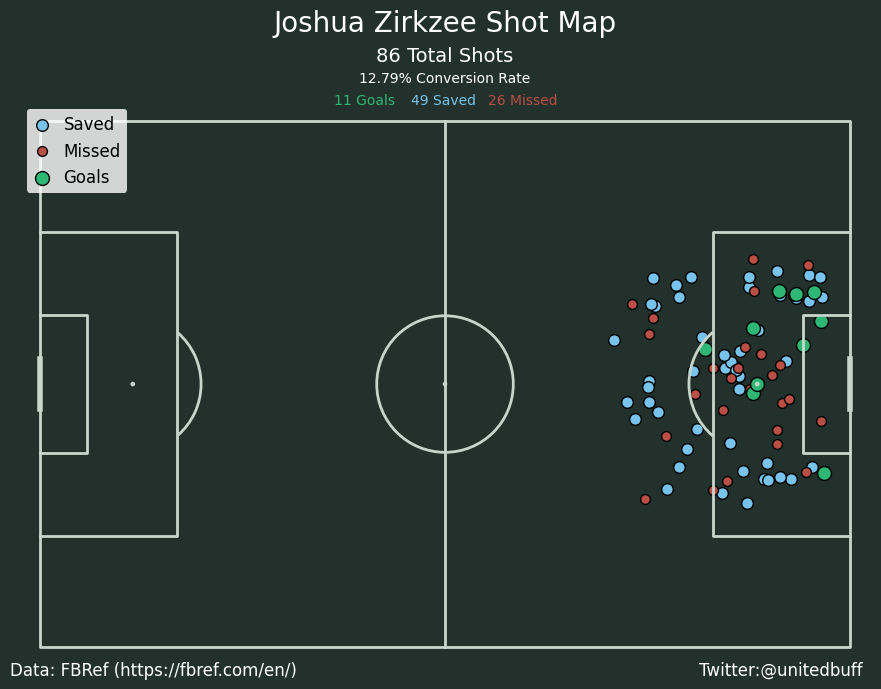

In [143]:
def plot_shot_map(playerName):
  filter_event = player_events.loc[player_events['period_display_name']!='PenaltyShootout'].reset_index(drop=True)
  shot_goal = filter_event.loc[filter_event['type_display_name']=="Goal"].reset_index(drop=True)
  saved_shot = filter_event.loc[filter_event['type_display_name']=="SavedShot"].reset_index(drop=True)
  missed_shot = filter_event.loc[filter_event['type_display_name']=="MissedShots"].reset_index(drop=True)

  # Set up the pitch
  goal_count = len(shot_goal.index)
  saved_shot_count = len(saved_shot.index)
  missed_shot_count = len(missed_shot.index)
  shots_count = goal_count + saved_shot_count + missed_shot_count
  try:
      shot_rate = round(goal_count/shots_count *100,2)
  except ZeroDivisionError:
      shot_rate = 0
  pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
  fig, ax = pitch.draw(figsize=(12, 7))
  fig.set_facecolor('#22312b')

  pitch.scatter(saved_shot.x, saved_shot.y, s=70, c = '#77c3ec', ax=ax,edgecolors="black",label='Saved')
  pitch.scatter(missed_shot.x, missed_shot.y, s=50, c = '#ba4f45', ax=ax,edgecolors="black",label='Missed')
  pitch.scatter(shot_goal.x, shot_goal.y, s=100, c = '#2eb774', ax=ax,edgecolors="black",label='Goals')

  # Set up the legend
  ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

  # Set the title
  ax_title = ax.set_title(f'{playerName} Shot Map', fontsize=20, color='white', pad=50)
  ax.text(0.5, 1.08, f'{shots_count} Total Shots', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
  ax.text(0.5, 1.04, f'{shot_rate}% Conversion Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
  ax.text(0.37, 1, f'{goal_count} Goals', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
  ax.text(0.46, 1, f'{saved_shot_count} Saved', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#77c3ec')
  ax.text(0.55, 1, f'{missed_shot_count} Missed', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')

  ax.text(-.01, -.02, 'Data: FBRef (https://fbref.com/en/)', ha='left', va='bottom', transform=ax.transAxes,fontdict={'size':12,'color':'white'})
  ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes,fontdict={'size':12,'color':'white'}) 
  #ax.text(f'{len(progressive_pass_success.index)} Successful\n{len(progressive_pass_fail.index)} Unsuccessful')
plot_shot_map(playerName)

# Call Function

In [11]:
#all_events = pd.read_csv('Manchester United Events 2023-2024 Preprocessed.csv',index_col=0)
all_events = pd.read_csv('Bologna Events 2023-2024 Preprocessed.csv',index_col=0)
all_events

C:\Users\MSI\AppData\Local\Temp\ipykernel_25032\3918177050.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events = pd.read_csv('Bologna Events 2023-2024 Preprocessed.csv',index_col=0)


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,goal_mouth_z,goal_mouth_y,is_shot,blocked_x,blocked_y,is_goal,card_type_value,cardType.displayName,match_id,is_own_goal,player_name,BlockedCross,Red,Blocked,GoalMouthZ,Foul,IntentionalGoalAssist,Assisted,FirstTouch,DivingSave,MissHigh,BoxRight,Longball,FreekickTaken,BoxCentre,KeeperSaveInTheBox,SmallBoxLeft,RelatedEventId,PassEndX,PassEndY,SecondYellow,HeadPass,KeeperSaved,KeeperMissed,LeftFoot,FormationSlot,JerseyNumber,PlayerCaughtOffside,LowRight,OtherBodyPart,Obstruction,OutOfBoxDeepRight,VoidYellowCard,RegularPlay,LayOff,LeadingToAttempt,KeeperThrow,ThirtyFivePlusLeft,Collected,BigChanceCreated,Hands,Angle,Feet,BoxLeft,BigChance,MissLeft,ParriedSafe,ThrowinSetPiece,OutOfBoxCentre,IndividualPlay,LowCentre,Head,ThrowIn,Throughball,GoalKick,Defensive,FromCorner,RightFoot,FromShotOffTarget,SixYardBlock,LastMan,OneOnOne,LowLeft,BlockedX,Volley,OutfielderBlock,OverRun,AerialFoul,SetPiece,OutOfBoxDeepLeft,Length,KeeperSaveInSixYard,MissRight,KeyPass,OutOfBoxLeft,Offensive,BlockedY,IntentionalAssist,KeeperWentWide,HighClaim,PlayerPosition,OppositeRelatedEvent,DeepBoxRight,HighLeft,Chipped,CornerTaken,CaptainPlayerId,DirectFreekick,SmallBoxRight,StandingSave,GoalDisallowed,HighCentre,HighRight,TeamPlayerFormation,Zone,IndirectFreekickTaken,DeepBoxLeft,ShotAssist,SavedOffline,ThirtyFivePlusCentre,ParriedDanger,LeadingToGoal,InvolvedPlayers,Yellow,Cross,SmallBoxCentre,GoalMouthY,FastBreak,OwnGoal,TeamFormation,Penalty,KeeperSaveObox,pass_recipient_name,pass_recipient_id
0,2.580454e+09,2,0,0.0,71,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.580454e+09,3,0,0.0,71,49.5,49.5,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,383956.0,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Joshua Zirkzee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.1,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicolás Domínguez,334653.0
2,2.580454e+09,4,0,2.0,71,35.6,48.8,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,334653.0,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nicolás Domínguez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.3,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sam Beukema,422739.0
3,2.580454e+09,5,0,4.0,71,25.3,26.5,0,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,422739.0,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Sam Beukema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
player_list = all_events[['player_name','player_id']]
player_list = player_list.drop_duplicates().dropna().reset_index(drop=True)
player_list

,player_name,player_id
0,Bruno Fernandes,123761.0
1,Casemiro,88526.0
2,Luke Shaw,118244.0
3,Lisandro Martínez,340105.0
4,André Onana,260843.0
5,Aaron Wan-Bissaka,331924.0
6,Raphaël Varane,93206.0
7,Mason Mount,343346.0
8,Alejandro Garnacho,437022.0
9,Antony,364315.0


In [12]:
# Set Player Name
playerName='Joshua Zirkzee'
interception_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Interception')].reset_index(drop=True)
tackle_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Tackle')].reset_index(drop=True)
take_on_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='TakeOn')].reset_index(drop=True)
passing = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Pass')].reset_index(drop=True)
receive_pass = all_events.loc[all_events.pass_recipient_name==f'{playerName}'].reset_index(drop=True)
player_events = all_events.loc[all_events.player_name==f'{playerName}'].reset_index(drop=True)

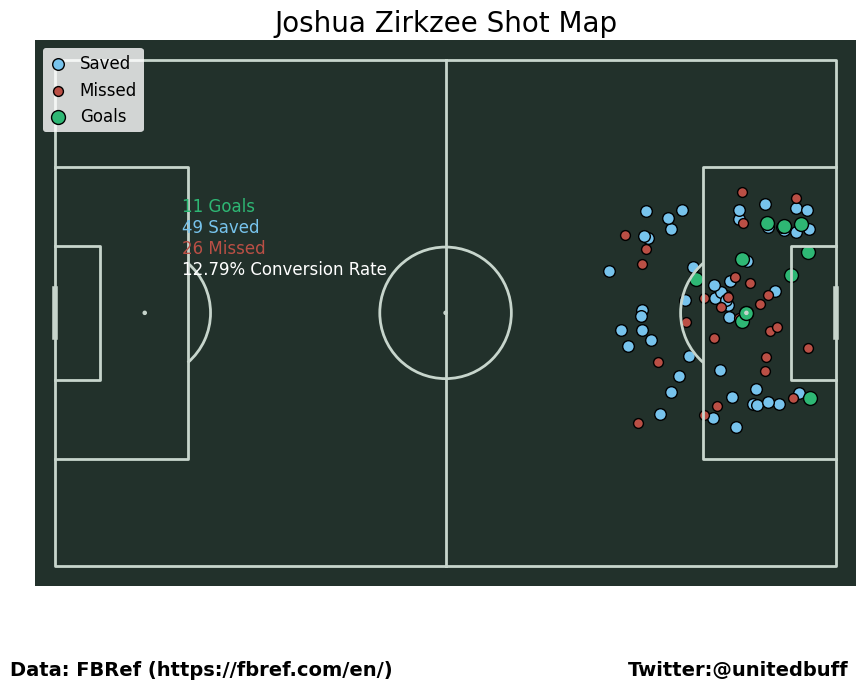

In [16]:
plot_shot_map(playerName)

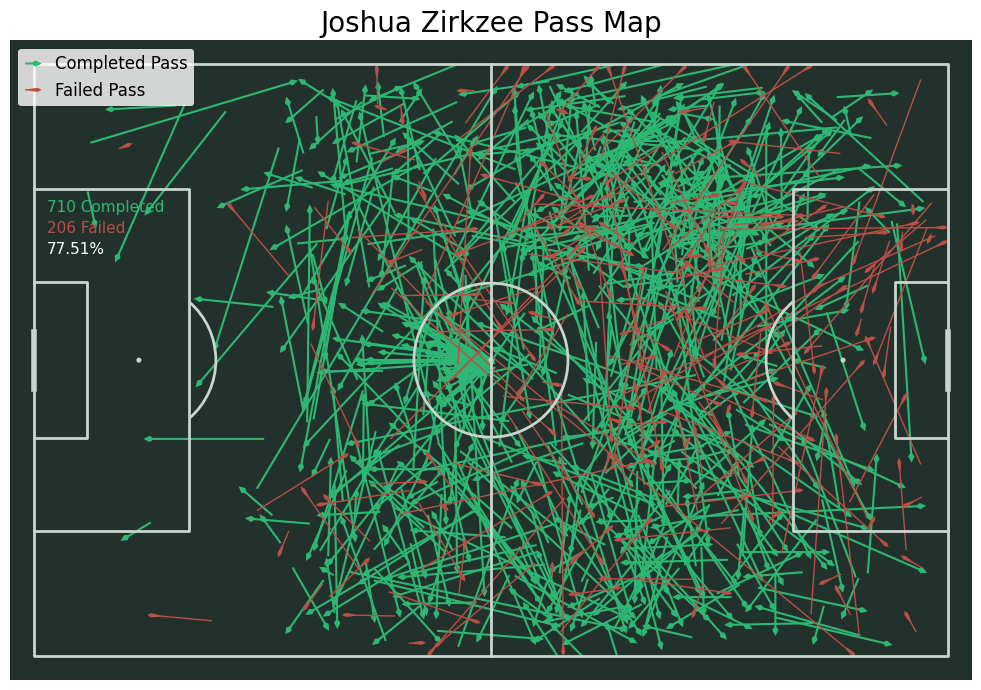

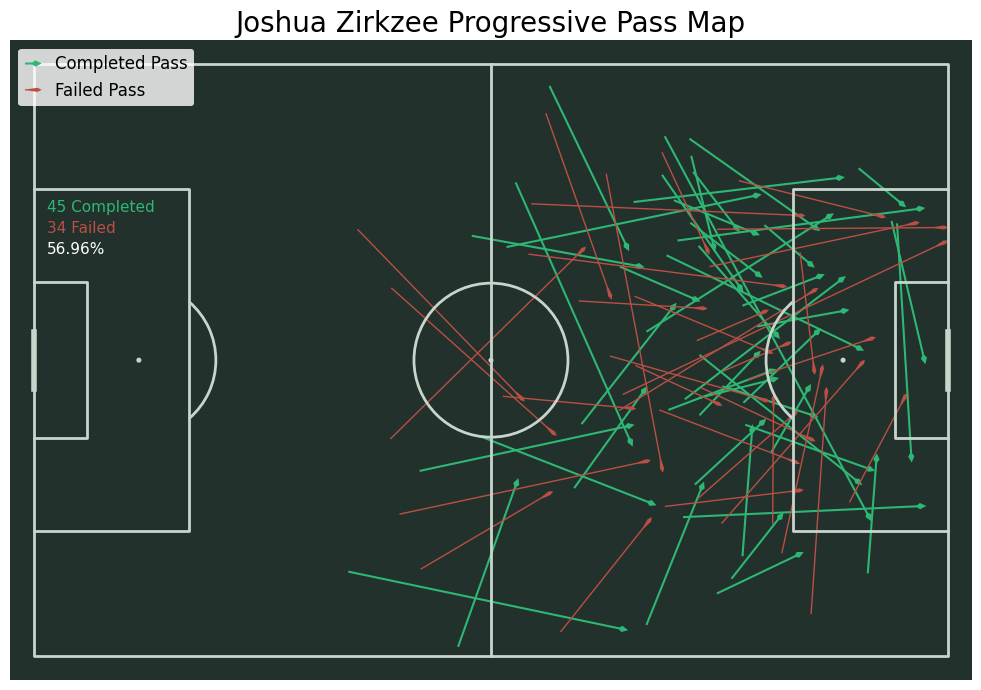

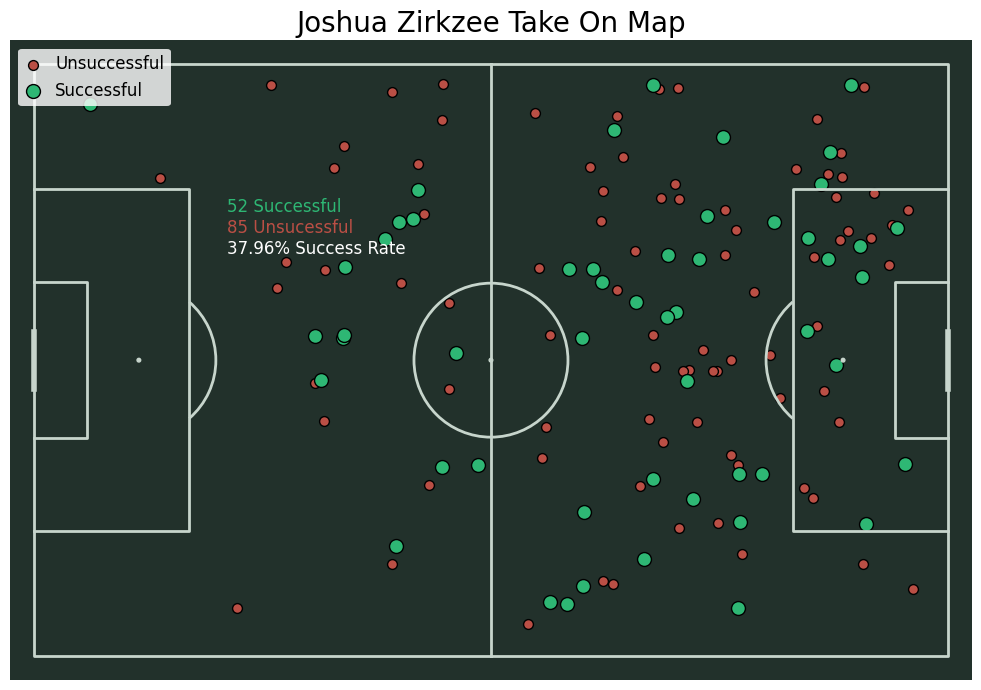

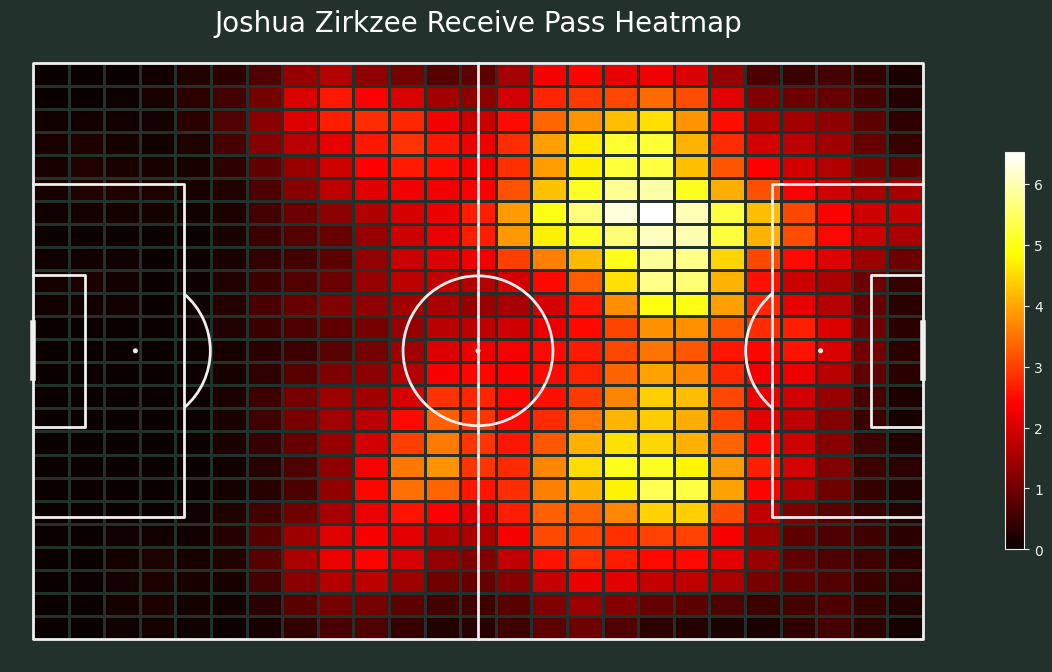

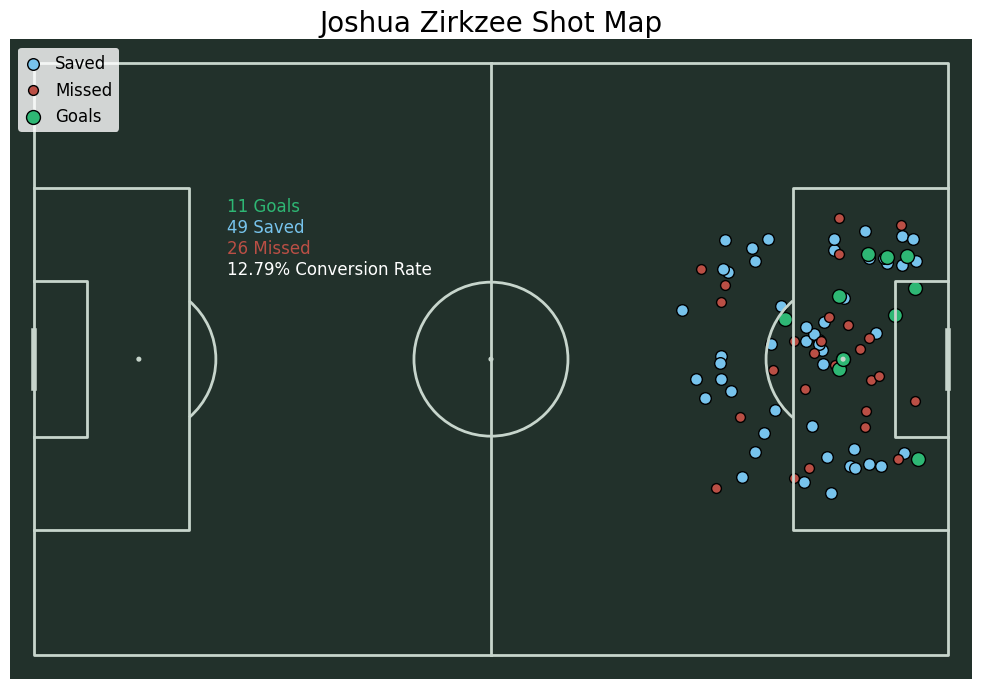

In [13]:
plot_pass_map(playerName)
plot_progressive_pass_map(playerName)
plot_take_on_map(playerName)
plot_receive_pass_map(playerName)
plot_shot_map(playerName)

## Next Dev
- Create Progressive Pass Receive Heatmap and Scatter
- Reposition details on the outside of plot
- Make the background same color

In [34]:
for playerName in player_list.player_name:
  #print(playerName)
  plot_pass_map(playerName)
  plot_progressive_pass_map(playerName)
  plot_receive_pass_map(playerName)
  plot_shot_map(playerName)

Output hidden; open in https://colab.research.google.com to view.

# Next Step
- Work on the other event types
- Try to check how to find which pass is creating chances
- Reposition details on the outside of the plot
- Merge Defensive Actions into one visualization
- Fix Progressive Pass Selection Based on the real definition